Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 05: Eye tracking

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 28, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

For this exercise sheet you will have 2 weeks and the sheet is also worth of 30 points. In this exercise sheet you will start to work with eye tracking data. Note that the data we will use here are not raw gaze data and contain coordinates of fixation points.

The dataset is distributed freely by a following study: [Wilming, N. Dryad](https://www.nature.com/articles/sdata2016126#data-citations). By clicking on the link in the section "Data Citations" you will get redirected to the page where you can download all the data openly distributed. Read below for description of each file.

##### necessary
*etdb_v1.0*: This is the main data file. The hdf5 file consists of all the fixation data and the metadata.  
*Read gaze data with python*: Python script to read hdf5 file as a dataframe.  
*Stimuli/i*: Zip file containing image stimuli used in the study. The encoding convention is same as in the dataframe.
##### optional
*Metadata*: This is the csv file giving overview of all studies.

In [1]:
%pip install h5py
# make sure to install h5py which is used in fixmat.py

Note: you may need to restart the kernel to use updated packages.


In [61]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
# am i allowed to import it?
from statsmodels.formula.api import ols
from statsmodels.stats.anova import *
from datas.fixmat import *

## Assignment 0: Peer review for sheet 04 [3 pts]

Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week. Follow a distributed comment guidelines if you are unsure.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 5, 9 | 1, 6  | 4, 7  | 7, 2 | 2, 11 | 8, 3 | 3, 10  | 11, 1  | 10, 4  | 6, 8  | 9, 5   |


## Assignment 1: Checking the data distribution [9 pts]

### a) loading datasets [0 pts]
As with any other datasets, the first step is to get an idea of the dataset. Check the meta data and column of the dataframe.

In [3]:
# use a fixmat.py to load the hdf5 format data as a panda dataframe
df, meta = load('datas/etdb_v1.0.hdf5', "Baseline")
df_old = df.copy()

In [4]:
meta

{'# Fix.': 203772,
 '# Obs.': 48,
 'Age': '23.1 (19-28)',
 'Article': 15.0,
 'Categories': '7,8,10,11',
 'Disp. Size (degree)': '29x22',
 'Display': 'SM1100',
 'Display resolution (pixels)': '1280x960',
 'Eye Tracker': 'EL II',
 'ID': 3,
 'Img. Pos. (pixel)': '0,0',
 'Img. size (pixel)': '1280x960',
 'PPD': 45.6,
 'Sampling freq. (Hz)': '500 Hz',
 'Task': 'FV',
 'V. Dur.': '6s',
 'V. dist. (cm) ': 80,
 'Val. error (degrees)': 0.3}

In [5]:
df.columns

Index(['SUBJECTINDEX', 'category', 'dataset_nr', 'end', 'eye', 'filenumber',
       'fix', 'pupil', 'start', 'trial', 'x', 'y'],
      dtype='object')

### b) data cleaning [3 pts]
We want to clean the dataframe so that it is handy for us to work with it.
- How many fixations do we have per category? ```agg``` function might be helpful.
- categories are encoded using a number. Add a column to the dataframe that has approporiate string value for that category (e.g. code 11.0 to "Pink-noise"). The category names can be found on Figure 2 of the paper.
- since measurements lasted for 6 seconds, any fixation points that have a onset time before 0 sec and end time more than 6 sec are erroneous. Remove these rows.
- also remove all rows with any NaN values.
- add a column called ```duration``` and compute the duration of each fixation.
- It is known from previous literature that fixations typically last between 100 msec to 400 msec. Remove all rows with unrealistic  fixation duration.
- check how many data points got removed for each category. Let's hope that we didn't delete too many rows from a single category.
- count the number of fixations for each trial. To do this, you can use the aggregate method to count the number of rows for each category.
- print the mean duration and the mean number of fixation across all trials. Are they in a realistic range?

In [6]:
# make a pandas series with the category as index and the number of fixations as row entry
fixations_old = df_old.groupby('category')['fix'].agg('count')
# loop over fixations and print the fixations per category
for category, count in fixations_old.iteritems():
    print('In category ' + str(int(category)) + ' we have ' + str(count) + ' fixations.')
    
# add column to df with appropriate string value for category, use a dict and the map function to do this
di = {7: 'Natural', 8: 'Urban', 10: 'Fractals', 11:'Pink-noise'}
df['category_name'] = df['category']
df['category_name'] = df['category_name'].map(di)

# drop rows with negative start values and end values higher than 6s
df = df[(df['start'] >= 0) & (df['end'] <= 6000)]

# drop all nan values
df = df.dropna()

# add column duration and compute duration for each fixations
df['duration'] = df['end'] - df['start']

# drop rows with a duration less than 100ms or more than 400
df = df[(df['duration'] >= 100) & (df['duration'] <= 400)]

# print newline for aesthetics
print()

# check how many data points got removed based on fixation count per category
fixations_new = df.groupby('category')['fix'].agg('count')
# compute difference between data points before and after cleaning the data
fixations_diff = fixations_old - fixations_new
for category, count in fixations_diff.iteritems():
    print('In category ' + str(int(category)) + ' we dropped ' + str(count) + ' data points.')
    
# print newline for aesthetics
print()

# count number of fixations for each trial and category
fixations_trial = df.groupby(['SUBJECTINDEX', 'trial'])['fix'].agg('count')
#for (subject, trial), fixation in fixations_trial.iteritems():
#    print('For subject ' + str(int(subject)) + ', trial ' + str(int(trial)) + " has " + str(fixation) +' fixations.')

# print the mean duration and the mean number of fixation across all trials
# seems very realistic to me
print(df.groupby(['SUBJECTINDEX', 'trial'])['fix', 'duration'].mean())

df.head()

In category 7 we have 52338 fixations.
In category 8 we have 56680 fixations.
In category 10 we have 52901 fixations.
In category 11 we have 41853 fixations.

In category 7 we dropped 12554 data points.
In category 8 we dropped 11835 data points.
In category 10 we dropped 12979 data points.
In category 11 we dropped 14603 data points.

                          fix    duration
SUBJECTINDEX trial                       
1.0          1.0    10.266666  266.799988
             2.0    12.500000  213.636368
             3.0     9.066667  258.266663
             4.0    10.294118  245.058823
             5.0    11.058824  210.705887
             6.0     8.500000  270.000000
             7.0    10.777778  217.333328
             8.0     6.800000  248.000000
             9.0     8.000000  282.888885
             10.0   11.000000  246.000000
             11.0   12.428572  219.428574
             12.0   10.200000  226.800003
             13.0    8.615385  253.692307
             14.0   10.000000  2

,SUBJECTINDEX,category,dataset_nr,end,eye,filenumber,fix,pupil,start,trial,x,y,category_name,duration
1,1.0,11.0,3.0,503.0,2.0,25.0,2.0,2872.182129,261.0,1.0,524.0,276.0,Pink-noise,242.0
2,1.0,11.0,3.0,819.0,2.0,25.0,3.0,2452.396484,541.0,1.0,592.0,393.0,Pink-noise,278.0
3,1.0,11.0,3.0,1103.0,2.0,25.0,4.0,2135.433594,865.0,1.0,367.0,339.0,Pink-noise,238.0
4,1.0,11.0,3.0,1399.0,2.0,25.0,5.0,2007.327393,1145.0,1.0,196.0,364.0,Pink-noise,254.0
6,1.0,11.0,3.0,2263.0,2.0,25.0,7.0,2346.299316,1977.0,1.0,687.0,356.0,Pink-noise,286.0


The mean duration and the mean number of fixations appear to be very realistic and conforming with the literature

### c) visualizing data distribution [3 pts]
Are there any inter-subject difference and effect of different category in our data?
- plot the mean duration for each category (4 x-values) and the mean duration for each subject (48 x-values).

- plot the mean number of fixations for each category (4 x-values) and the mean number of fixation for each subject (48 x-values).

4  should be 4
48  should be 48
4  should be 4
48  should be 48


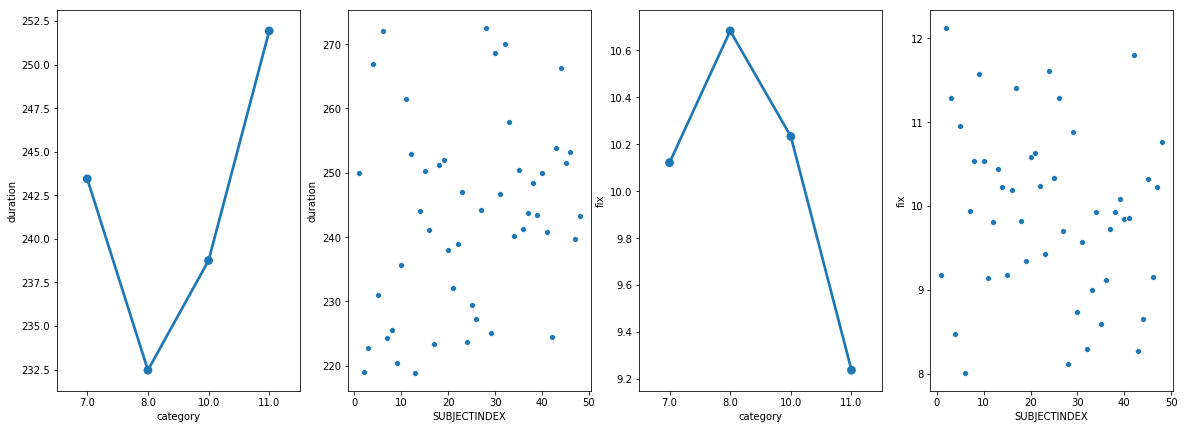

In [7]:
# a lot more to do was kind of rushing this one

# creating data sets with mean duration
duration_category = df.groupby('category')['duration'].agg('mean').reset_index()
duration_subject = df.groupby('SUBJECTINDEX')['duration'].agg('mean').reset_index()
# creating data sets with mean number of fixation
fixations_category = df.groupby('category')['fix'].agg('mean').reset_index()
fixations_subject = df.groupby('SUBJECTINDEX')['fix'].agg('mean').reset_index()

print(len(duration_category), ' should be 4')
print(len(duration_subject), ' should be 48')
print(len(fixations_category), ' should be 4')
print(len(fixations_subject), ' should be 48')

fix, axes = plt.subplots(ncols=4, figsize=(20, 7))

sns.pointplot(x = 'category', y = 'duration', data=duration_category, ax=axes[0])
sns.scatterplot(x = 'SUBJECTINDEX', y = 'duration', data=duration_subject, ax=axes[1])
sns.pointplot(x = 'category', y = 'fix', data=fixations_category, ax=axes[2])
sns.scatterplot(x = 'SUBJECTINDEX', y = 'fix', data=fixations_subject, ax=axes[3])

plt.show()

### d) normally distributed data [3 pts]
As ANOVA and lots of other statistical tests can be used only for normally distributed varaibles, it makes sense to find out whether the fixation duration and the number of fixations per trial is also normally distributed. This can be done with a Q-Q-Plot, which  is a graphical technique for determining if two data sets come from populations with a common distribution, in this case a normal distribution (for more information, klick [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33o.htm)).
- make a Q-Q plot of the variable *fixation duration*. Is it approximately normally distributed?
- make a Q-Q plot of the variable *# fixation per trial*. Is it approximately normally distributed?

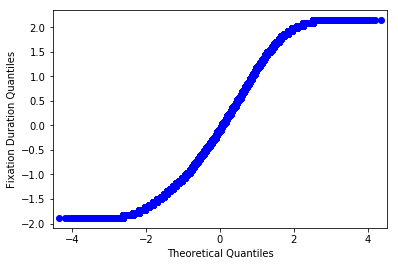

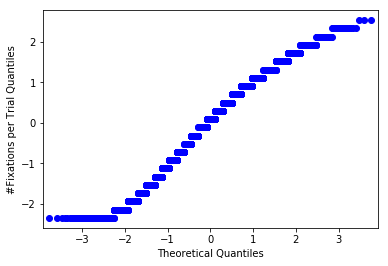

In [8]:
# Q-Q plot for the variable fixation duration - does not seem normally distributed
fig = sm.qqplot(df['duration'], ylabel='Fixation Duration Quantiles', fit=True) 

# Q-Q plot for the variable #fixation per trial - does not seem normally distributed
fig2 = sm.qqplot(fixations_trial, ylabel='#Fixations per Trial Quantiles', fit=True)


# show the two figures
plt.show()

what do you think?

## Assignment 2: Hypothesis testing [3 pts]

### a) one way ANOVA [3 pts]
Now it's time to really prove our intuition. Test the following null hypotheses:  
$H01$: There is no difference in fixation duration across 4 different categories.  
$H02$: There is no difference in the number of fixations across 4 different categories.

What do you find?

In [9]:
# H01
# imported the ols from the last exercise, is it allowed?
# not entirely sure which data to plot here - values seem very extreme
model_h1 = ols('duration ~ category', df).fit()
anova_h1 = anova_lm(model_h1, typ=1)
print(anova_h1)

                df        sum_sq       mean_sq           F        PR(>F)
category       1.0  1.330038e+06  1.330038e+06  246.995531  1.298364e-55
Residual  151799.0  8.174172e+08  5.384865e+03         NaN           NaN


In [10]:
# H02
model_h2 = ols('fix ~ category', df).fit()
anova_h2 = anova_lm(model_h2, typ=1)
print(anova_h2)

                df        sum_sq       mean_sq          F         PR(>F)
category       1.0  1.323439e+04  13234.390199  459.92918  7.062423e-102
Residual  151799.0  4.367992e+06     28.774844        NaN            NaN


what do you say?

## Assignment 3: Binning [4 pts]

### a) distribution of # fixation [2 pts]
Now we would like to know if there's a difference in terms of fixation numbers at different time segment.
- make a histogram with x axis being the start time of fixation
- the bin size should be 1 sec. In total there would be 6 bins.
- average over all subjects and images, just make a one simple plot
- figure out mean fixation duration for each bin and print it


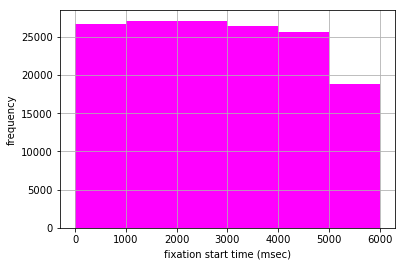

the mean value for the  1 . bin is:  538.8696824445776
the mean value for the  2 . bin is:  1497.7974636879746
the mean value for the  3 . bin is:  2497.6697064796012
the mean value for the  4 . bin is:  3498.608787878788
the mean value for the  5 . bin is:  4496.642871044334
the mean value for the  6 . bin is:  5379.251290236765


In [73]:
# bins for the dividing the data into 6 different parts according to second intervalls
bins=[0,1000,2000,3000,4000,5000,6000]

# plot the histogram of starting values for bins 1-6 seconds
plt.hist(df['start'], color='magenta', alpha=1, bins=bins)
plt.grid()
plt.xlabel('fixation start time (msec)')
plt.ylabel('frequency')
plt.show()

# compute means for each bin, the bin edges and the binnumber
bin_means, bin_edges, binnumber = stats.binned_statistic(df['start'], df['start'], statistic='mean', bins=bins)
# print the mean for each bin
for i in range(len(bin_means)):
    print('the mean value for the ',i+1,'. bin is: ', bin_means[i])

### b) leftward bias [2 pts]
If you took Action & Cognition I, you have probably heard about the leftward bias in human's fixation behavior. It is known that people tend to look more at the left visual field for the initial first second. Check whether this holds for our dataset as well.
- make a pointplot with x-axis as the x-coordinate of each fixation point and y-axis as the time bin to which the fixation point belongs to.
- mark the confidence interval around each point.
- make a vertical line at middle point of the x values. The x-coordinate of the fixation point in the data is based on the coordinate system using the display resolution. You can find out the information about display resolution by taking a look at the meta data.

[579. 644. 665. 660. 647. 638.] median

[   0. 1000. 2000. 3000. 4000. 5000. 6000.] edges

[1 1 1 ... 6 6 6] number


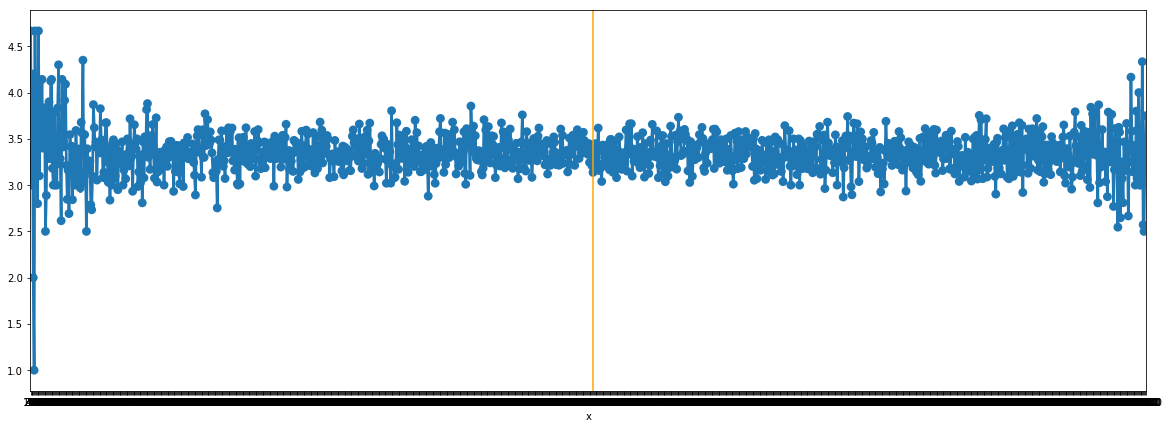

In [79]:
#digitized_x = np.digitize(x=, bins=bins)
#print(digitized_x)

#print(df.head())
#time_bin = [df[digitized == i]['x'] for i in range(1, len(bins))]

bin_median, bin_edges, binnumber = stats.binned_statistic(df['start'], df['x'], statistic='median', bins=bins)

print(bin_median, 'median')
print()
print(bin_edges, 'edges')
print()
print(binnumber, 'number')

#print(digitized)
#print(time_bin)
#liste = []
#for i in time_bin:
    #print(i)
 #   liste.append(time_bin['x'])
    
#print(liste)    

fix, ax = plt.subplots(ncols=1, figsize=(20, 7))
sns.pointplot(x=df['x'], y=binnumber, xlabel='x coordinates', ylabel='bins', ci=0.2, ax=ax)
ax.axvline(np.median(bin_median), color='orange')
plt.show()

## Assignment 4: Heatmap [4 pts]
Now let's use heatmap to visualize which part of pictures is fixated for how long. It would be also good to know if there's a difference between categories.
- make a heatmap for data consisting of each categories and then averaged across all data.
- mark a central point in the plot.
- you can use ```numpy.histogram2d``` to compute a bi-dimensional histogram.
- then you can use ```pyplot.imshow``` to plot these histogram.
- don't forget to use the parameter ```extent``` to control for the bounding box to which the image should fit in.
- if you want to use other functions that's surely fine as well.

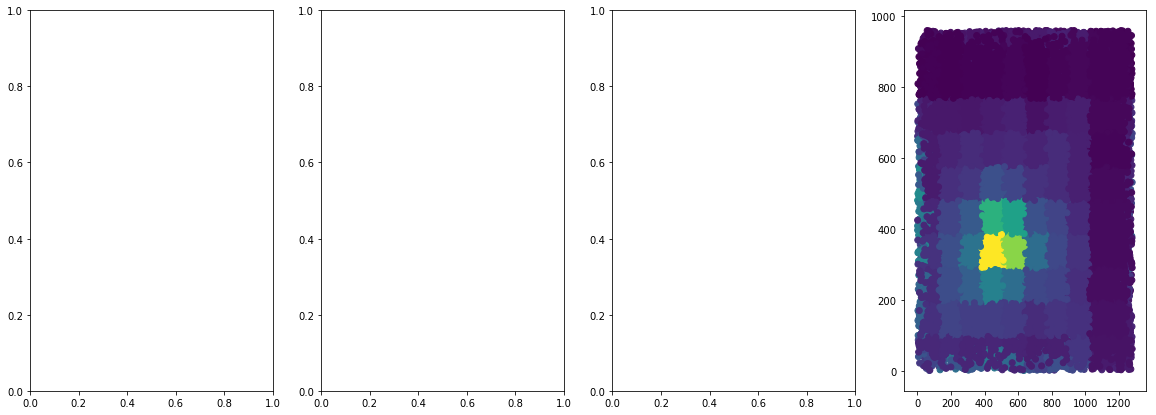

In [115]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 7))

#print(df[df['category' == str(11.0)]])

category_df = df.groupby('category')
category_07 = category_df.get_group(7.0)
category_08 = category_df.get_group(8.0)
category_10 = category_df.get_group(10.0)
category_11 = category_df.get_group(11.0)

#print(category_07['category'])
#print(category_df['category'])

heatmap_07, x_edg07, y_edg07 = np.histogram2d(x=category_07['x'], y=category_07['y'])
heatmap_08, x_edg08, y_edg08 = np.histogram2d(x=category_08['x'], y=category_08['y'])
heatmap_10, x_edg10, y_edg10 = np.histogram2d(x=category_10['x'], y=category_10['y'])
heatmap_11, x_edg11, y_edg11 = np.histogram2d(x=category_11['x'], y=category_11['y'])

"""print(heatmap_07)
print(x_edg07)
print(y_edg07)
"""

xidx07 = np.clip(np.digitize(category_07['x'], x_edg07), 0, heatmap_07.shape[0]-1)
yidx07 = np.clip(np.digitize(category_07['y'], y_edg07), 0, heatmap_07.shape[1]-1)
c07 = heatmap_07[xidx07, yidx07]
axes[0] = plt.scatter(category_07['x'], category_07['y'], c=c07)

xidx08 = np.clip(np.digitize(category_08['x'], x_edg08), 0, heatmap_08.shape[0]-1)
yidx08 = np.clip(np.digitize(category_08['y'], y_edg08), 0, heatmap_08.shape[1]-1)
c08 = heatmap_08[xidx08, yidx08]
axes[1] = plt.scatter(category_08['x'], category_08['y'], c=c08)

xidx10 = np.clip(np.digitize(category_10['x'], x_edg10), 0, heatmap_10.shape[0]-1)
yidx10 = np.clip(np.digitize(category_10['y'], y_edg10), 0, heatmap_10.shape[1]-1)
c10 = heatmap_10[xidx10, yidx10]
axes[2] = plt.scatter(category_10['x'], category_10['y'], c=c10)

xidx11 = np.clip(np.digitize(category_11['x'], x_edg11), 0, heatmap_11.shape[0]-1)
yidx11 = np.clip(np.digitize(category_11['y'], y_edg11), 0, heatmap_11.shape[1]-1)
c11 = heatmap_11[xidx11, yidx11]
axes[3] = plt.scatter(category_11['x'], category_11['y'], c=c11)


plt.show()

#plt.imshow(axes)

## Assignment 5: Scanpath [5 pts]
We want to know whether different scan behaviour is used when viewing images of different categories. Scanpath is a path followed by the eyes when viewing a stimulus. Scanpaths are useful for analyzing cognitive intent, interest, and salience. It has an advantage to a heatmap because the information about temporal structure of viewing behaviour can be plotted.
- make four plots, one for each category.
- randomely choose one trial for which you will plot a scanpath.
- mark fixation points based on the x-y coordinates.
- plot the *saccade path* from one fixation point to another one.
- make sure that the order of fixation can be read out from the plot. E.g. earlier fixations could have a light color whereas later fixations could have dark colors.
- also include information about the duration of each fixation. One way to do it is the use the size of the fixation marker.
- plot the background image superimposed with the scanpath. 

In [122]:
#fig, axes = plt.subplots(ncols=4, figsize=(20, 7))

# get random trial sample for each category
rnd_smpl_07 = category_07[category_07.trial == np.random.choice(category_07['trial'].unique())].reset_index(drop=True)
rnd_smpl_08 = category_08[category_08.trial == np.random.choice(category_08['trial'].unique())].reset_index(drop=True)
rnd_smpl_10 = category_10[category_10.trial == np.random.choice(category_10['trial'].unique())].reset_index(drop=True)
rnd_smpl_11 = category_11[category_11.trial == np.random.choice(category_11['trial'].unique())].reset_index(drop=True)

                                                       
#random_sample07 = category_07['trial'].sample()
#print(random_sample07)

0      82.0
1      82.0
2      82.0
3      82.0
4      82.0
5      82.0
6      82.0
7      82.0
8      82.0
9      82.0
10     82.0
11     82.0
12     82.0
13     82.0
14     82.0
15     82.0
16     82.0
17     82.0
18     82.0
19     82.0
20     82.0
21     82.0
22     82.0
23     82.0
24     82.0
25     82.0
26     82.0
27     82.0
28     82.0
29     82.0
       ... 
101    82.0
102    82.0
103    82.0
104    82.0
105    82.0
106    82.0
107    82.0
108    82.0
109    82.0
110    82.0
111    82.0
112    82.0
113    82.0
114    82.0
115    82.0
116    82.0
117    82.0
118    82.0
119    82.0
120    82.0
121    82.0
122    82.0
123    82.0
124    82.0
125    82.0
126    82.0
127    82.0
128    82.0
129    82.0
130    82.0
Name: trial, Length: 131, dtype: float32


# Citation
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) An extensive dataset of eye movements during viewing of complex images. Scientific Data 4: 160126. https://doi.org/10.1038/sdata.2016.126  
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) Data from: An extensive dataset of eye movements during viewing of complex images. Dryad Digital Repository. https://doi.org/10.5061/dryad.9pf75